#Scripting to get fractional cover
This document is the final version of the scripting needed to get fractional cover for a series of polygons. 
Inputs are a polygon layer, and need a label saying where they are (tbc)


In [1]:
#Standard libs
import geopandas
import pyogrio
import fiona
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pystac_client
#DEA, odc, dc libs
import odc.aws
import odc.geo.xr
from datacube.utils import masking
import odc.stac
from dea_tools.dask import create_local_dask_cluster
#change some variables (probably don't need the AWS_NO_SIGN_REQUEST one)
sys.path.insert(1, '../Tools/')
os.environ['AWS_NO_SIGN_REQUEST'] = 'Yes'


In [2]:
#setup the odc environment (this does the aws part)
def setup_odc_environment():
    catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")
    odc.stac.configure_rio(
        cloud_defaults=True,
        aws={"aws_unsigned": True},
        )
    return catalog
    





In [9]:
#get polygons file, using gdf
path_to_data = "C:/Users/willo/OneDrive - UNSW/Desktop/Honours/farm_comp.gpkg"
gdf = geopandas.read_file(path_to_data)
#check id if needed gdf["id"]
gdf['id'] = gdf.index
attribute_col = "id"


In [4]:
#setting up odc and dask environments
catalog = setup_odc_environment()
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 8,Total memory: 13.01 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58651,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 13.01 GiB
Comm: tcp://127.0.0.1:58659,Total threads: 8
Dashboard: /proxy/58660/status,Memory: 13.01 GiB
Nanny: tcp://127.0.0.1:58654,


2024-07-22 04:55:20,956 - distributed.scheduler - WARNING - Worker failed to heartbeat for 35709s; attempting restart: <WorkerState 'tcp://127.0.0.1:58659', name: 0, status: running, memory: 0, processing: 0>
2024-07-22 04:55:22,302 - distributed.nanny - WARNING - Restarting worker
2024-07-22 09:58:16,514 - distributed.scheduler - WARNING - Worker failed to heartbeat for 18158s; attempting restart: <WorkerState 'tcp://127.0.0.1:63651', name: 0, status: running, memory: 0, processing: 0>
2024-07-22 09:58:19,404 - distributed.nanny - WARNING - Restarting worker


In [7]:
#adding in collections and start/finish times. Change the end date to a year long period for testing.
start_date = "2000-01-01"
end_date = "2020-01-01"
collections_frac = ["ga_ls_fc_3"]
collections_water = ["ga_ls_wo_3"]
#add water atts because I couldn't find it using odc. Need to work on this using a command in odc.load
water_atts = {
    'data_type' : 'unit8',
    'units': '1',
    'nodata': '1',
    'flags_definition': {'dry': {'bits': [7, 6, 5, 4, 3, 2, 1, 0],
      'values': {'0': True},
      'description': 'No water detected'},
      'wet': {'bits': [7, 6, 5, 4, 3, 2, 1, 0],
      'values': {'128': True},
      'description': 'Clear and Wet'},
      'cloud': {'bits': 6,
      'values': {'0': False, '1': True},
      'description': 'Cloudy'},
      'nodata': {'bits': 0,
      'values': {'0': False, '1': True},
      'description': 'No data'},
      'high_slope': {'bits': 4,
      'values': {'0': False, '1': True},
      'description': 'High slope'},
      'cloud_shadow': {'bits': 5,
      'values': {'0': False, '1': True},
      'description': 'Cloud shadow'},
      'noncontiguous': {'bits': 1,
      'values': {'0': False, '1': True},
      'description': 'At least one EO band is missing or saturated'},
      'terrain_shadow': {'bits': 3,
      'values': {'0': False, '1': True},
      'description': 'Terrain shadow'},
      'water_observed': {'bits': 7,
      'values': {'0': False, '1': True},
      'description': 'Classified as water by the decision tree'},
      'low_solar_angle': {'bits': 2,
      'values': {'0': False, '1': True},
      'description': 'Low solar incidence angle'}},
    'crs': 'EPSG:32655',
    'grid_mapping': 'spatial_ref'}


In [10]:
results_dask = {}
#itterates through each row in gdf
for index, row in gdf.iterrows():
    #not needed, just updates
    print(f'Feature: {index + 1}/{len(gdf)}')

    bbox = row.geometry.bounds
    #The layer column holds information about the land ownership
    location = row["layer"]
    #do an initial catalog search to see what items to query using odc.load
    query_frac = catalog.search(
        bbox=bbox,
        collections=collections_frac,
        datetime=f"{start_date}/{end_date}"
    )
    items_frac = list(query_frac.items())
    #just another update, not needed
    print(f"Found: {len(items_frac):d} datasets")
    #find (??) the data using odc.load based on the queried items. Note this uses Dask which is significantly quicker
    #than loading locally. This is because it loads the data in chunks and only loads the data when needed
    # note this does not actually load anything. Dask performs all operations lazily, so it only loads the data when
    #it is needed. This is why we need to use .load() to actually load the data
    frac = odc.stac.load(
        items_frac,
        resolution=30,
        groupby="solar_day",
        bbox=bbox,
        chunks={"time": 1, "x": 2048, "y": 2048}
    )
    #same as above, but need the water layer for cloud and water masking
    query_water = catalog.search(
        bbox=bbox,
        collections=collections_water,
        datetime=f"{start_date}/{end_date}"
    )
    items_water = list(query_water.items())
    print(f"Found: {len(items_water):d} datasets")
    wo = odc.stac.load(
        items=items_water,
        resolution=30,
        groupby="solar_day",
        bbox=bbox,
        chunks={"time": 1, "x": 2048, "y": 2048}
    )
    #now for the operations (remeber these are lazy)
    #add water attributes to the water layer. See above notes on needing to work on this
    print("1")
    wo.water.attrs =  water_atts
    #converting water layers to uint8. Needed for masking. Can't do this on whole dataarray, breaks it
    print("2")
    wo['water'] = wo['water'].astype(np.uint8)
    #Make mask layer using the DEA provided function. Shoudl make own at some point but this works well
    print("3")
    wo_mask = masking.make_mask(wo.water, dry=True)
    #mask the fractional cover layer with the mask layer
    print("4")
    fc_masked = frac.where(wo_mask)
    #calculate the percentage of no data in the masked layer. If it is greater than 50% then we remove the data
    print("5")
    percent_nodata = fc_masked.pv.isnull().mean(dim=['x', 'y'])
    fc_masked = fc_masked.sel(time=percent_nodata < 0.5)
    #calculate the mean of the fractional cover layer through time (it gives mean values for each polygon at each 
    #time step)
    print("6")
    fc_through_time = fc_masked[['pv', 'npv', 'bs', 'ue']].mean(dim=['x', 'y'])

    #add the data to the results_dask dictionary
    print("7")
    attribute_val = row[attribute_col]
    #add location (ie ownership) to the data as a coordinate. Same with the id. this makes for easier processing
    #as a pandas dataframe later on, I'm still not comfortable with xarray
    print("8")
    fc_through_time = fc_through_time.assign_coords(location=location,
                                                    id = attribute_val)
    #finally load the data using dask
    print("9")
    results_dask[attribute_val] = fc_through_time.load()

    

print("Done!")


Feature: 1/3
Found: 877 datasets
Found: 855 datasets
1
2
3
4
5
6
7
8
9
Feature: 2/3
Found: 856 datasets
Found: 834 datasets
1
2
3
4
5
6
7
8
9
Feature: 3/3
Found: 877 datasets
Found: 855 datasets
1
2
3
4
5
6
7
8
9
Done!


In [14]:
#as above but no dask. Don't run this, it will take forever
results_no_dask = {}
for index, row in gdf.iterrows():
    print(f'Feature: {index + 1}/{len(gdf)}')
    print(row)
    bbox = row.geometry.bounds
    location = row["layer"]
    query_frac = catalog.search(
        bbox=bbox,
        collections=collections_frac,
        datetime=f"{start_date}/{end_date}"
    )
    items_frac = list(query_frac.items())
    print(f"Found: {len(items_frac):d} datasets")
    frac = odc.stac.load(
        items_frac,
        resolution=30,
        groupby="solar_day",
        bbox=bbox
    )
    #Plot to test
    #rgb(frac, bands=['bs', 'pv', 'npv'], col='time')
    query_water = catalog.search(
        bbox=bbox,
        collections=collections_water,
        datetime=f"{start_date}/{end_date}"
    )
    items_water = list(query_water.items())
    print(f"Found: {len(items_water):d} datasets")
    wo = odc.stac.load(
        items=items_water,
        resolution=30,
        groupby="solar_day",
        bbox=bbox
    )
    wo.water.attrs =  water_atts
    wo['water'] = wo['water'].astype(np.uint8)
    wo_mask = masking.make_mask(wo.water, dry=True)
    fc_masked = frac.where(wo_mask)
    percent_nodata = fc_masked.pv.isnull().mean(dim=['x', 'y'])
    fc_masked = fc_masked.sel(time=percent_nodata < 0.5)
    fc_through_time = fc_masked[['pv', 'npv', 'bs', 'ue']].mean(dim=['x', 'y'])
    fc_through_time = fc_through_time.assign_coords(location=location)

    attribute_val = row[attribute_col]
    fc_through_time = fc_through_time.assign_coords(location=location,
                                                    id = attribute_val)
    results_no_dask[attribute_val] = fc_through_time

    



Feature: 1/5
layer                                                 private
id                                                          1
geometry    MULTIPOLYGON (((147.52374832960462 -30.8727760...
Name: 0, dtype: object
Found: 1 datasets
Found: 1 datasets
Feature: 2/5
layer                                                    mmnr
id                                                          2
geometry    MULTIPOLYGON (((147.5463811018581 -30.71074414...
Name: 1, dtype: object
Found: 1 datasets


d:\honours\remote_sensing\.venv\Lib\site-packages\xarray\core\duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Found: 1 datasets
Feature: 3/5
layer                                                    mmnr
id                                                          3
geometry    MULTIPOLYGON (((147.53884642096162 -30.9609288...
Name: 2, dtype: object
Found: 1 datasets


d:\honours\remote_sensing\.venv\Lib\site-packages\xarray\core\duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Found: 1 datasets
Feature: 4/5
layer                                                    mmnr
id                                                          4
geometry    MULTIPOLYGON (((147.54620244189917 -30.7338368...
Name: 3, dtype: object
Found: 1 datasets


d:\honours\remote_sensing\.venv\Lib\site-packages\xarray\core\duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Found: 1 datasets
Feature: 5/5
layer                                                 private
id                                                          5
geometry    MULTIPOLYGON (((147.49885756473552 -31.0393974...
Name: 4, dtype: object
Found: 1 datasets


d:\honours\remote_sensing\.venv\Lib\site-packages\xarray\core\duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Found: 1 datasets


d:\honours\remote_sensing\.venv\Lib\site-packages\xarray\core\duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [11]:


df = pd.DataFrame(columns=['pv', 'npv', 'bs', 'location', 'id'])

for item in results_dask:
    temp_df = results_dask[item].to_pandas().reset_index()
    df = pd.concat([df, temp_df])

df



C:\Users\willo\AppData\Local\Temp\ipykernel_10048\3044972159.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp_df])


,pv,npv,bs,location,id,time,ue,spatial_ref
0,21.822222,65.222221,11.655556,miller,0,2000-01-08 23:48:55.232819,9.022223,32655.0
1,14.322222,65.466667,18.866667,miller,0,2000-02-09 23:48:48.408899,7.477778,32655.0
2,7.122222,68.122223,23.411112,miller,0,2000-02-25 23:48:42.672861,7.155556,32655.0
3,13.184211,60.986843,24.473684,miller,0,2000-03-28 23:48:36.352502,12.013158,32655.0
4,14.222222,33.211113,51.133335,miller,0,2000-04-29 23:48:22.744272,8.222222,32655.0
...,...,...,...,...,...,...,...,...
506,11.520833,5.277778,81.277779,craig,2,2019-11-20 23:56:23.916582,5.243055,32655.0
507,10.708333,1.673611,86.555557,craig,2,2019-11-28 23:38:39.209842,4.916667,32655.0
508,12.076389,0.048611,87.041664,craig,2,2019-12-06 23:56:23.610020,4.916667,32655.0
509,11.000000,6.656000,81.143997,craig,2,2019-12-14 23:37:51.595377,4.104000,32655.0


In [13]:
test = df.groupby(['time', 'location'], as_index=False).agg({'pv': 'mean', 'npv': 'mean', 'bs': 'mean'})
#test2 = df_2.groupby(['time', 'location'], as_index=False).agg({'pv': 'mean', 'npv': 'mean', 'bs': 'mean'})




In [22]:
results_dask

{1: <xarray.Dataset> Size: 17kB
 Dimensions:      (time: 859)
 Coordinates:
   * time         (time) datetime64[ns] 7kB 1987-05-27T23:25:36.229081 ... 202...
     spatial_ref  int32 4B 32655
     location     <U7 28B 'private'
     id           int64 8B 1
 Data variables:
     pv           (time) float32 3kB 38.97 10.88 12.73 ... 80.25 79.26 76.53
     npv          (time) float32 3kB 51.21 68.12 63.36 22.16 ... 15.06 15.8 18.27
     bs           (time) float32 3kB 8.717 19.96 22.77 ... 2.464 2.686 3.001,
 2: <xarray.Dataset> Size: 17kB
 Dimensions:      (time: 858)
 Coordinates:
   * time         (time) datetime64[ns] 7kB 1987-05-27T23:25:36.229081 ... 202...
     spatial_ref  int32 4B 32655
     location     <U4 16B 'mmnr'
     id           int64 8B 2
 Data variables:
     pv           (time) float32 3kB 44.73 10.21 12.04 83.94 ... 62.9 66.22 68.71
     npv          (time) float32 3kB 45.9 36.44 53.34 10.42 ... 32.84 29.04 26.75
     bs           (time) float32 3kB 8.251 52.12 33.35 4

: 

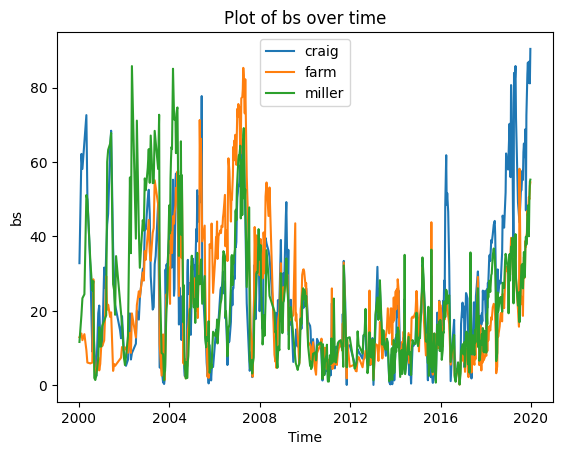

In [20]:

# Group the data by location
groups = test.groupby('location')

# Plot each group separately with different colors
for name, group in groups:
    plt.plot(group['time'], group['bs'], label=name)

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('bs')

# Set the title of the plot
plt.title('Plot of bs over time')

# Add a legend
plt.legend()

# Show the plot
plt.show()

import plotly.express as px

fig = px.line(df, x='time', y='bs', color='location')
fig.update_layout(
    title='Plot of bs over time',
    xaxis_title='Time',
    yaxis_title='bs',
    hovermode='x',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)
fig.show()

In [ ]:
# Calculate average fractional cover for `bs`, `pv` and `npv` over time




